In [1]:
# -*- coding: utf-8 -*- 

import config

import os
import numpy as np
import pandas as pd

from pathlib import Path

from hbayesdm.models import ra_prospect

import nibabel as nib
# import nipype as nip
# import nilearn as nil

from bids import BIDSLayout, BIDSValidator
from tqdm import tqdm

import pickle

In [2]:
layout = BIDSLayout(config.DATA_DIR, derivatives=True)

/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)
/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/bids/layout/layout.py:591: UserWarning: Derivative indexing was requested, but no valid datasets were found in the specified locations (['/home/mybirth0407/datasets/ds000005/derivatives']). Note that all BIDS-Derivatives datasets must meet all the requirements for BIDS-Raw datasets (a common problem is to fail to include a 'dataset_description.json' file in derivatives datasets).
Example contents of 'dataset_description.json':
{"Name": "Example dataset", "BIDSVersion": "1.0.2", "PipelineDescription": {"Name": "Example pipeline"}}
  json.dumps(EXAMPLE_DERIVATIVES_DESCRIP

In [3]:
# make config
x, y, z, t = nib.load(
    layout.get(
        subject=layout.get(target='subject', return_type='id')[0],
        return_type='file',
        suffix='bold',
        extension='nii.gz'
    )[0]).shape

cfg = {
    'slicing_time': layout.get_tr(),
    'time_dim': t
}
cfg['time_indices'] = [int(cfg['slicing_time'] * _t / config.RESPONSE_TR) for _t in range(cfg['time_dim'])]

In [4]:
frmi_subject_run = {}
# simple structure for fmri_subject_run
# fmri_subject_run: {
#     subj: {
#         niis: [run1, run2, run3],
#         events: [run1, run2, run3]
#     }
# }

for subject_id in tqdm(layout.get(target='subject', return_type='id')):
    if subject_id not in frmi_subject_run.keys():
        frmi_subject_run[subject_id] = {
            'niis': layout.get(subject=subject_id, return_type='file', suffix='bold', extension='nii.gz'),
            'events': layout.get(subject=subject_id, return_type='file', suffix='events', extension='tsv')
        }
    else: # subjID is already exists..
        print(f'error! {subject_id}')
        break

100%|██████████| 16/16 [00:00<00:00, 79.35it/s]


In [5]:
df_all = []

for subject_id in layout.get(target='subject', return_type='id'):
    for i, df_path in enumerate(frmi_subject_run[subject_id]['events']):
        df = pd.read_table(df_path)
        df['subjID'] = int(subject_id)
        df['run'] = i + 1
        df_all.append(df)
    
df_all = pd.concat(df_all)

In [6]:
columns = df_all.columns.copy()

In [7]:
df_all = df_all[df_all['respcat'] != -1]
df_all['onset'] = df_all['onset'].astype(np.int)
df_all['cert'] = 0 # certain..?
df_all['gamble'] = df_all['respcat']
df_all.head()

INFO:numexpr.utils:Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,onset,duration,parametric loss,distance from indifference,parametric gain,gain,loss,PTval,respnum,respcat,response_time,subjID,run,cert,gamble
1,4,3,-0.0227,-0.4147,-0.189,18,12,6.12,2,1,1.793,1,1,0,1
2,8,3,0.1273,0.2519,-0.389,10,15,-4.85,3,0,1.637,1,1,0,0
3,18,3,0.1773,-0.0814,0.211,34,16,18.16,1,1,1.316,1,1,0,1
4,24,3,-0.3727,-0.0814,-0.189,18,5,13.05,1,1,1.670,1,1,0,1
5,28,3,0.0273,-0.4147,0.011,26,13,13.13,2,1,1.232,1,1,0,1


In [ ]:
model = ra_prospect(data=df_all, ncore=4)
print(model.all_ind_pars)
params = model.all_ind_pars
params.to_csv('models/ra_prospect_params.tsv', sep='\t', index=False)

In [8]:
params = pd.read_csv('models/ra_prospect_params.tsv', sep='\t')
params['subjID'] = params.index + 1

In [9]:
params.head()

,rho,lambda,tau,subjID
0,0.452520,1.020956,17.606066,1
1,0.356679,1.449137,17.684474,2
2,0.296322,1.422933,17.229850,3
3,0.292687,1.399908,17.330297,4
4,0.234196,1.235551,16.831544,5


In [10]:
try: 
    df_X = pd.merge(df_all, params, how='left', on=['subjID'])
except:
    df_all.columns = columns
    df_X = pd.merge(df_all, params, how='left', on=['subjID'])

df_X['utility_risky'] = (df_X['gain'] ** df_X['rho']) - (df_X['lambda'] * (df_X['loss'] ** df_X['rho']))

In [11]:
df_X.head()

,onset,duration,parametric loss,distance from indifference,parametric gain,gain,loss,PTval,respnum,respcat,response_time,subjID,run,cert,gamble,rho,lambda,tau,utility_risky
0,4,3,-0.0227,-0.4147,-0.189,18,12,6.12,2,1,1.793,1,1,0,1,0.45252,1.020956,17.606066,0.555487
1,8,3,0.1273,0.2519,-0.389,10,15,-4.85,3,0,1.637,1,1,0,0,0.45252,1.020956,17.606066,-0.642273
2,18,3,0.1773,-0.0814,0.211,34,16,18.16,1,1,1.316,1,1,0,1,0.45252,1.020956,17.606066,1.351917
3,24,3,-0.3727,-0.0814,-0.189,18,5,13.05,1,1,1.670,1,1,0,1,0.45252,1.020956,17.606066,1.583613
4,28,3,0.0273,-0.4147,0.011,26,13,13.13,2,1,1.232,1,1,0,1,0.45252,1.020956,17.606066,1.109179


In [12]:
from nltools.external import glover_hrf

def data2bold(utilities, time_stamp, time_resolution=0.01, hrf=glover_hrf(0.01, oversampling=1)):
    assert len(utilities) == len(time_stamp)
    
    output = np.zeros(int((time_stamp.max()+30) / time_resolution))
    
    # make data impulse
    for time, value in zip(time_stamp, utilities):
        output[int(time/time_resolution)] = value
        
    # hrf convolution
    return np.convolve(output,hrf,mode='same')

In [13]:
df_utility_risky_bold = pd.DataFrame(columns=['subjID', 'run', 'onset', 'duration', 'utility_risky_bold'])

for name, group in tqdm(df_X.groupby(['subjID', 'run'])):
    subject_id, run = name[0], name[1]
    
    utility_risky_bold = data2bold(
        group['utility_risky'].to_numpy(),
        group['onset'].to_numpy(),
        config.RESPONSE_TR
    )
    
    utility_risky_bold_for_time = [
        np.mean(utility_risky_bold[int(row['onset']) * 100: int(row['onset'] + row['duration']) * 100])
            for i, row in group.iterrows()
    ]
    
    data = np.array([
        [subject_id] * len(utility_risky_bold_for_time),
        [run] * len(utility_risky_bold_for_time),
        group['onset'].to_numpy(),
        group['duration'].to_numpy(),
        utility_risky_bold_for_time]
    )
    data = pd.DataFrame(data).T
    data.columns=['subjID', 'run', 'onset', 'duration', 'utility_risky_bold']
    df_utility_risky_bold = df_utility_risky_bold.append(data)
    
df_utility_risky_bold['subjID'] = df_utility_risky_bold['subjID'].astype(int)
df_utility_risky_bold['run'] = df_utility_risky_bold['run'].astype(int)

100%|██████████| 48/48 [00:02<00:00, 18.31it/s]


In [14]:
df_utility_risky_bold.head()

,subjID,run,onset,duration,utility_risky_bold
0,1,1,4.0,3.0,0.002003
1,1,1,8.0,3.0,0.002910
2,1,1,18.0,3.0,0.001455
3,1,1,24.0,3.0,0.000668
4,1,1,28.0,3.0,0.003555


In [15]:
train = {}

for name0, group0 in tqdm(df_utility_risky_bold.groupby(['subjID'])):
    X, y = [], []
    
    for name1, group1 in group0.groupby(['run']):
        subject_id, run = name0, name1
        img =  nib.load(frmi_subject_run[f'{subject_id:02d}']['niis'][run-1]).get_fdata()

        for i, row in group1.iterrows():
            i = int(row['onset'] / 2)
            j = int(i + row['duration'] / 2 + 1) # slicing
            X.append(row['utility_risky_bold'])
            y.append(np.mean(img[:,:,:,i:j], axis=3))

    if f'{subject_id:02d}' not in train.keys():
        train[f'{subject_id:02d}'] = {'X': np.array(X), 'y': np.array(y)}

100%|██████████| 16/16 [00:43<00:00,  2.75s/it]


In [ ]:
from sklearn import linear_model

dict_coefs = {}

for key, value in tqdm(train.items()):
    X = value['X']
    y = value['y']
    coefs = []
    
    for i in range(y.shape[1]):
        i_v = []
        for j in range(y.shape[2]):
            j_v = []
            for k in range(y.shape[3]):
                reg = linear_model.LinearRegression().fit(X.reshape(-1,1), y[:, i, j, k])
                j_v.append(np.array([float(reg.coef_), float(reg.intercept_)]))
            i_v.append(np.array(j_v))
        coefs.append(np.array(i_v))
    dict_coefs[key] = np.array(coefs)

In [ ]:
with open('dict_coefs.pkl', 'wb') as fp:
    pickle.dump(dict_coefs, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
with open('dict_coefs.pkl', 'rb') as f:
    dict_coefs = pickle.load(f)

In [18]:
anat = layout.get(
        subject=layout.get(target='subject', return_type='id')[0],
        return_type='file',
        suffix='T1w',
        extension='nii.gz')
print(anat)

['/home/mybirth0407/datasets/ds000005/sub-01/anat/sub-01_T1w.nii.gz']


In [19]:
img = nib.Nifti1Image(np.array(dict_coefs['01'])[...,0], np.eye(4))

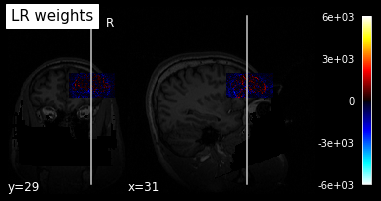

In [20]:
from nilearn.plotting import plot_stat_map, show

plot_stat_map(img, bg_img=anat[0],
              title="LR weights", display_mode="yx")

show()